# Part 1: Stitching pairs of images

In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
from pathlib import Path
from skimage.io import imread as _imread
from skimage.io import imsave
from skimage.color import rgb2gray
from skimage.util import img_as_ubyte

data_dir = Path("part1")


def imread(filename: str, as_gray: bool = False, bonus: str = None):
    """
    Read image data for this part.
    
    Args:
        filename (str): Filename in the data folder corresponding to this part.
        as_gray (bool, optional): Return the image as grayscale [0, 1].
        bonus (str, optional): Bonus dir 
    """
    path = data_dir
    if bonus:
        path /= "bonus"
        path /= bonus
    path /= filename

    im = _imread(path)
    if as_gray and (im.ndim == 3):
        return rgb2gray(im)
    else:
        return im


def imwrite(filename: str, data, bonus: str = None):
    path = data_dir
    if bonus:
        path /= "bonus"
        path /= bonus
    path /= filename

    data = img_as_ubyte(data)
    imsave(path, data)


In [3]:
import cv2 as cv
from skimage.feature.util import FeatureDetector, DescriptorExtractor
from skimage.util import img_as_ubyte


class SIFT(FeatureDetector, DescriptorExtractor):
    """
    Wrapper class for OpenCV to use scikit-image detector-extractor.
    
    Args:
        n_features (int, optional): The number of best features to retain. 
        n_octave_layers (int, optional): The number of layers in each octave.
        contrast_threshold (float, optional): The contrast threshold used to filter out 
            weak features in semi-uniform (low-contrast) regions.
        edge_threshold (float, optional): The threshold used to filter out edge-like 
            features. 
        sigma (float, optional): The sigma of the Gaussian applied to the input image 
            at the 0th octave.
    """

    def __init__(
        self,
        n_features=100,
        n_octave_layers=3,
        contrast_threshold=0.04,
        edge_threshold=10,
        sigma=1.6,
    ) -> None:
        self.detector = cv.SIFT_create(
            nfeatures=n_features,
            nOctaveLayers=n_octave_layers,
            contrastThreshold=contrast_threshold,
            edgeThreshold=edge_threshold,
            sigma=sigma,
        )

        self.keypoints = None
        self.descriptors = None

    def detect(self, image) -> None:
        # cv only takes in 8U
        image = img_as_ubyte(image)
        self.keypoints_ = self.detector.detect(image)

        # extract relevant info from cv structure
        self.keypoints = np.array([keypoint.pt[::-1] for keypoint in self.keypoints_])

    def extract(self, image, keypoints=None) -> None:
        if keypoints is not None:
            raise NotImplementedError(f"'keypoints' has no effect, using cached result")

        # cv only takes in 8U
        image = img_as_ubyte(image)
        _, self.descriptors = self.detector.compute(image, self.keypoints_)


In [4]:
from scipy.spatial.distance import cdist


def swap_by(v, cond):
    v[cond, 0], v[cond, 1] = v[cond, 1], v[cond, 0]
    return v


def ubcmtach(desc1, desc2, threshold):
    """
    Matches two sets of SIFT descriptors.append
    
    This function uses the algorithm suggested by D. Lowe to reject matches that are too ambiguous.
    
    Args:
        desc1 : 
        desc2 :
        threshold (float): 

    Returns:
        TBD
    """
    dist2 = cdist(desc1, desc2, metric="sqeuclidean")

    # find 1st and 2nd closest match distance
    index_closest = np.argpartition(dist2, 2)[:, :2]
    dist_closest = np.take_along_axis(dist2, index_closest, axis=-1)
    # sort in each partition
    need_swap = dist_closest[:, 0] > dist_closest[:, 1]
    index_closest = swap_by(index_closest, need_swap)
    dist_closest = swap_by(dist_closest, need_swap)

    # compare ratio
    index_closest_mask = dist_closest[:, 0] * threshold < dist_closest[:, 1]

    matches = [
        (m0, m1)
        for m0, (m1, mask) in enumerate(zip(index_closest[:, 0], index_closest_mask))
        if mask
    ]
    matches = np.array(matches)

    return matches, dist_closest[index_closest_mask, 0]


In [5]:
from skimage.measure.fit import BaseModel
from skimage.transform._geometric import _center_and_normalize_points


class HomographyModel(BaseModel):
    def estimate(self, src, dst) -> bool:
        """
        Estimate homography model from data.

        Args:
            data ((N, 4) array): N points in a 2D space, arrange in (x1, y1, x2, y2).

        Returns:    
            bool: True if model sucessfully estimates.
        """
        n = len(src)

        A1 = np.hstack(
            [
                src,
                np.ones((n, 1)),
                np.zeros((n, 3)),
                -dst[:, 0][:, np.newaxis] * src,
                -dst[:, 0][:, np.newaxis],
            ]
        )

        A2 = np.hstack(
            [
                np.zeros((n, 3)),
                src,
                np.ones((n, 1)),
                -dst[:, 1][:, np.newaxis] * src,
                -dst[:, 1][:, np.newaxis],
            ]
        )

        A = np.empty((2 * n, A1.shape[-1]))
        A[0::2, :] = A1
        A[1::2, :] = A2

        _, _, vh = np.linalg.svd(A, full_matrices=False)
        if np.isclose(vh[-1, -1], 0):
            return False

        # save the H
        self.params = np.reshape(vh[-1, :], (3, 3))

        return True

    def residuals(self, src, dst):
        """
        Determine residuals of data to model.

        Args:
            src ((N, 2) array): Source coordinates.
            dst ((N, 2) array): Destination coordinates

        Returns:
            (N, ) array: 
        """
        return np.hypot(*(self.predict(src) - dst).T)

    def predict(self, data):
        """
        Predict x-y coordinates using the estimated model.

        Args:
            data ((N, 2) array):

        Returns:
            (N, 2) array: 
        """
        n = len(data)

        data = np.hstack([data, np.ones((n, 1))])
        data_fit = data @ self.params.T
        # convert back from homogeneous coordinate
        data_fit = data_fit[:, :-1] / data_fit[:, -1][:, np.newaxis]

        return data_fit


def ransac(
    data,
    model_class,
    min_samples,
    residual_threshold,
    max_trials=100,
    random_state=None,
):
    """
    RANSAC

    Args:
        data ((N, 2) array): 
        model_class :
        min_samples (int): Minimum number of data points to fit the model.
        residual_threshold (float): Maximum distance for a data point to be classified 
            as an inlier.
        max_trials (int, optional): Maximum number of iterations for RANSAC.
        random_State ({None, int, `numpy.random.Generator`}, optional): A seed to 
            initialize the BitGenerator.
    """
    n_samples = len(data)

    # model for this dataset, following skimage.measure.fit.BaseModel
    model = model_class()

    random_state = np.random.default_rng(random_state)

    best_inliers_num = 0
    # best_residuals_sum = np.inf
    best_residuals_mean = np.inf
    best_inliers = []

    for i_trial in range(max_trials):
        # select subset, forbit duplicate item
        sampling_mask = random_state.choice(n_samples, min_samples, replace=False)
        samples = data[sampling_mask, :]

        success = model.estimate(samples[:, 2:], samples[:, :2])
        if not success:
            # fail to fit for some reason
            continue
        residuals = np.abs(model.residuals(data[:, 2:], data[:, :2]))

        inliers = residuals < residual_threshold
        # residuals_sum = np.sum(residuals ** 2)
        residuals_mean = np.mean(residuals[inliers] ** 2)
        inliers_num = np.count_nonzero(inliers)

        if (
            # more inliers
            (inliers_num > best_inliers_num)
            # same number of inliers, but less residuals sum
            or (
                (inliers_num == best_inliers_num)
                # and (residuals_sum < best_residuals_sum)
                and (residuals_mean < best_residuals_mean)
            )
        ):
            best_inliers = inliers
            # best_residuals_sum = residuals_sum
            best_residuals_mean = residuals_mean
            best_inliers_num = inliers_num

            # TODO early stop conditions

    if best_inliers.any():
        # print(f".. best_residual_sum={best_residuals_sum:.6f}")
        print(f".. best_residual_mean={best_residuals_mean:.6f}")
        print(f".. best_inliers_num={best_inliers_num}")

        # estimate the model with all inliers
        data_inliers = data[best_inliers, :]
        model.estimate(data_inliers[:, 2:], data_inliers[:, :2])
    else:
        model = None
        best_inliers = None

    return model, best_inliers


In [107]:
from matplotlib.patches import Circle
from skimage.feature import plot_matches
from skimage.transform import warp, EuclideanTransform, ProjectiveTransform


def register_images(
    images,
    method="first",
    # SIFT feature extraction
    n_features=1000,
    n_octave_layers=4,
    contrast_threshold=0.04,
    edge_threshold=10,
    sigma=1.6,
    # putative matching
    extraction_ratio=1.5,
    # ransac
    residual_threshold=1,
    max_trials=10000,
    # debug features
    show_features=False,
    show_putative_matches=False,
    show_ransac=False,
    show_homography_fitting=False,
):
    """
    Register all images with respect to the first one.

    Args:
        images (list of 2D array): Images to register.
        method ({'first', 'consecutive'}, str, optional): Image pair matching method.
        show_features (bool, optional): Show detected SIFT features.
        show_putative_matches (bool, optional): Show putative match results.
        show_ransac (bool, optional): Show RANSAC inliers matches.
        show_homography_fitting (bool, optional): Show homography fitting result.

    Returns:
        TBD
    """
    # TODO sanity check for `mode`

    detector = SIFT(
        n_features=n_features,
        n_octave_layers=n_octave_layers,
        contrast_threshold=contrast_threshold,  # Harris response
        edge_threshold=edge_threshold,
        sigma=sigma,
    )

    # main feature variables
    keypoints = []
    descriptors = []
    matches = [[]]  # ignore first comparison
    models = []

    keypoints_raw = []

    # sanity check, every image should have the same size
    shape0 = images[0].shape
    for i, image in enumerate(images[1:], 1):
        if shape0 != image.shape:
            pass #raise ValueError(f"image {i} has different shape {image.shape}")

    for i, image in enumerate(images):
        detector.detect(image)
        keypoints.append(detector.keypoints)
        print(f"image {i}, {len(detector.keypoints)} keypoints")
        keypoints_raw.append(detector.keypoints_)

        detector.extract(image)
        descriptors.append(detector.descriptors)

    if show_features:
        # show all images in horizontal
        fig, ax = plt.subplots(1, len(images), figsize=(15, 5))
        for i, (im, kp, kp_raw) in enumerate(zip(images, keypoints, keypoints_raw)):
            ax[i].imshow(im, cmap="gray")
            for (y, x), kp in zip(kp, kp_raw):
                c = Circle((x, y), kp.size, color="r", fill=False)
                ax[i].add_patch(c)
            fig.canvas.flush_events()

    # find matches
    i_ref = 0
    for i_src in range(1, len(images)):
        new_matches, score = ubcmtach(
            descriptors[i_ref], descriptors[i_src], extraction_ratio
        )
        print(f"{i_ref}<>{i_src}, {len(new_matches)} matches")
        matches.append(new_matches)

        if method == "first":
            # do nothing, keep using the first image
            pass
        elif method == "consecutive":
            i_ref = i_src

    if show_putative_matches:
        i_ref = 0
        for i_src in range(1, len(images)):
            fig, ax = plt.subplots(figsize=(15, 5))
            plot_matches(
                ax,
                images[i_ref],
                images[i_src],
                keypoints[i_ref],
                keypoints[i_src],
                matches[i_src],
            )
            fig.canvas.flush_events()

            if method == "consecutive":
                i_ref = i_src

    # build data array for RANSAC
    i_ref = 0
    for i_src in range(1, len(images)):
        m_ref = keypoints[i_ref][matches[i_src][:, 0], :]
        m_src = keypoints[i_src][matches[i_src][:, 1], :]

        # flip from y-x to x-y
        data = np.hstack([m_ref[:, ::-1], m_src[:, ::-1]])

        model, inliers = ransac(
            data,
            HomographyModel,
            min_samples=4,
            residual_threshold=residual_threshold,
            max_trials=max_trials,
        )
        print(f"{i_ref}<>{i_src}, [ransac] {np.count_nonzero(inliers)} inliers")
        models.append(model)

        # update match result with inliers-only
        matches[i_src] = matches[i_src][inliers, :]

        if show_ransac:
            fig, ax = plt.subplots(figsize=(15, 5))
            plot_matches(
                ax,
                images[i_ref],
                images[i_src],
                keypoints[i_ref],
                keypoints[i_src],
                matches[i_src],
            )

        if show_homography_fitting:
            # calculate target match
            m_src = m_src[inliers, :]
            m_dst_fit = model.predict(m_src[:, ::-1])[:, ::-1]

            # show fitting result
            fig, ax = plt.subplots(figsize=(15, 5))
            plot_matches(
                ax,
                images[i_ref],
                images[i_src],
                m_dst_fit,
                m_src,
                np.array([(i, i) for i in range(len(m_src))]),
            )

        if method == "consecutive":
            i_ref = i_src

    # it is easier to work with ProjectiveTransform object
    matrix = [ProjectiveTransform(model.params) for model in models]
    matrix = [EuclideanTransform()] + matrix  # add back the first one, an I

    return matrix


def shape_to_corners(shape):
        ny, nx = shape
        return np.vstack([(0, 0), (nx, 0), (nx, ny), (0, ny)])


def stitch_images(images, matrix, method="first", show_unmerged=False):
    # build transformations
    _matrix = []
    m_ref = matrix[0]
    for m in matrix[1:]:
        _matrix.append(m_ref + m)
        if method == "consecutive":
            m_ref = m
    matrix = [matrix[0]] + _matrix

    # determine final output size
    corners_ref = shape_to_corners(images[0].shape)
    corners_ref_h = np.hstack([corners_ref, np.ones((4, 1))])

    extents = []
    for m in matrix:
        corners_dst = corners_ref_h @ m.params.T
        corners_dst = corners_dst[:, :-1] / corners_dst[:, -1][:, np.newaxis]
        extents.append(corners_dst)
    extents = np.vstack(extents)
    extent_max, extent_min = np.max(extents, axis=0), np.min(extents, axis=0)

    # convert as shape
    shape = np.ceil(extent_max - extent_min).astype(int)
    # reference image need to sheift `extent_min`
    offset = EuclideanTransform(translation=-extent_min)
    print(f"[final] (nx, ny)={tuple(shape)}, offset={tuple(-extent_min)}")
    # we work with (ny, nx) form
    shape = shape[::-1]

    # apply translation to every transformation
    matrix = [m + offset for m in matrix]

    # start warping everyone
    images_warp = []
    for im, m in zip(images, matrix):
        im_warp = warp(im, m.inverse, output_shape=shape, cval=np.nan)
        images_warp.append(im_warp)

    if show_unmerged:
        n = len(images_warp)
        fig, ax = plt.subplots(1, n, figsize=(15, 5 * n))
        for i, image in enumerate(images_warp):
            ax[i].imshow(image, cmap="gray")

    # merge to same image by copy-paste
    #merged = np.zeros_like(images_warp[0])
    #for im in images_warp:
    #    # we cut and past on top of previous one
    #    mask = im > 0
    #    merged[mask] = im[mask]

    # merge to same image by average
    merged = np.nanmean(np.array(images_warp), axis=0)
    merged[merged == np.nan] = 0

    return merged

    # DEBUG
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.invert_yaxis()
    # reference
    xs, ys = zip(*extent0)
    ax.plot(xs, ys)
    ax.scatter(xs[0], ys[0], marker="o")
    # warped
    xs, ys = zip(*extents[1])
    ax.plot(xs, ys)
    ax.scatter(xs[0], ys[0], marker="o")
    # fix axis orientation
    ax.axis("equal")


### Baseline question, left-right stitching

image 0, 1000 keypoints
image 1, 1000 keypoints
0<>1, 130 matches


/home/andy/.conda/envs/ece549-mp/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/andy/.conda/envs/ece549-mp/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


.. best_residual_mean=0.209835
.. best_inliers_num=24
0<>1, [ransac] 24 inliers
[<EuclideanTransform(matrix=
    [[1., 0., 0.],
     [0., 1., 0.],
     [0., 0., 1.]]) at 0x7f4826675340>, <ProjectiveTransform(matrix=
    [[ 2.08781127e-03, -1.13317783e-04, -9.91795210e-01],
     [ 1.43232073e-04,  2.21379432e-03, -1.27791329e-01],
     [ 4.63630431e-07,  3.13123493e-07,  1.53117790e-03]]) at 0x7f4824474a90>]
[final] (nx, ny)=(1448, 539), offset=(647.733494243667, 83.45949141955091)
[final] (nx, ny)=(1448, 539), offset=(647.733494243667, 83.45949141955091)
[final] (nx, ny)=(1448, 539), offset=(647.733494243667, 83.45949141955091)


/tmp/ipykernel_829/3554497059.py:43: UserWarning: part1/merged.png is a low contrast image
  imsave(path, data)


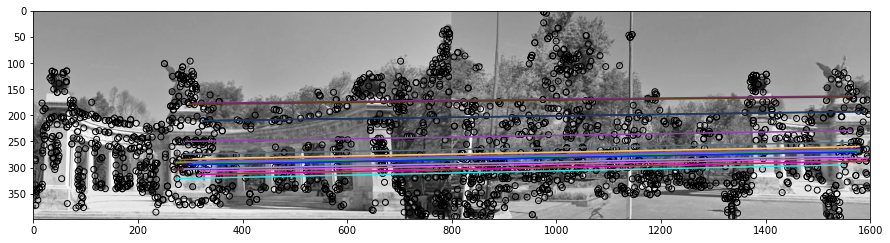

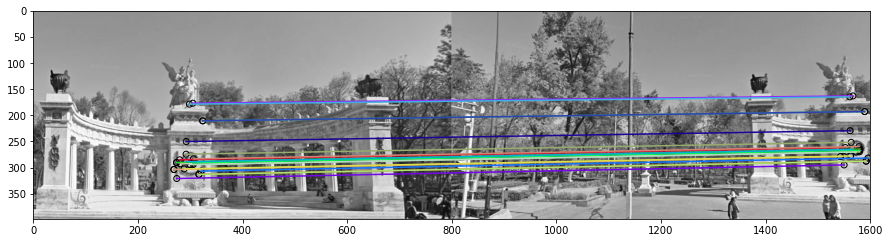

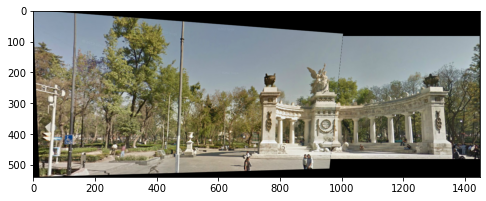

In [241]:
names = ("right", "left")

images = [imread(f"{name}.jpg", as_gray=True) for name in names]
matrix = register_images(
    images,
    method="first",
    # SIFT feature extraction
    n_features=1000,
    n_octave_layers=3,
    contrast_threshold=0.04,
    edge_threshold=5,
    sigma=1.6,
    # putative matching
    extraction_ratio=1.5,
    # ransac
    residual_threshold=1,
    max_trials=10000,
    # debug
    show_features=False,
    show_putative_matches=False,
    show_ransac=True,
    show_homography_fitting=True,
)

print(matrix)

# problem statement asks for colored panorama
images = [imread(f"{name}.jpg", as_gray=False) for name in names]
images = np.array(images)
# we do each color separately
#   [i h w c] -> [c i h w]
#   [0 1 2 3] -> [3 0 1 2]
images = np.transpose(images, [3, 0, 1, 2])
images = list(images)

merged_split = []
for images_split in images:
    merged = stitch_images(images_split, matrix, method="first")
    merged_split.append(merged)
merged_split = np.array(merged_split)
# convert back to comply with RGB
#   [c h w] -> [h w c]
#   [0 1 2] -> [1 2 0]
merged_split = np.transpose(merged_split, [1, 2, 0])

fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(merged_split)

imwrite("merged.png", merged_split)



# Bonus

## Multi-image stitching
Simple, send in multiple images and stitch together. Using default parameters.

image 0, 1000 keypoints
image 1, 1001 keypoints
image 2, 1001 keypoints
0<>1, 252 matches
1<>2, 315 matches


/home/andy/.conda/envs/ece549-mp/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/andy/.conda/envs/ece549-mp/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


.. best_residual_mean=0.186999
.. best_inliers_num=184
0<>1, [ransac] 184 inliers
.. best_residual_mean=0.149088
.. best_inliers_num=255
1<>2, [ransac] 255 inliers
[final] (nx, ny)=(1253, 472), offset=(-0.0, -0.0)
[final] (nx, ny)=(1253, 472), offset=(-0.0, -0.0)
[final] (nx, ny)=(1253, 472), offset=(-0.0, -0.0)


/tmp/ipykernel_27926/3717498767.py:230: RuntimeWarning: Mean of empty slice
  merged = np.nanmean(np.array(images_warp), axis=0)


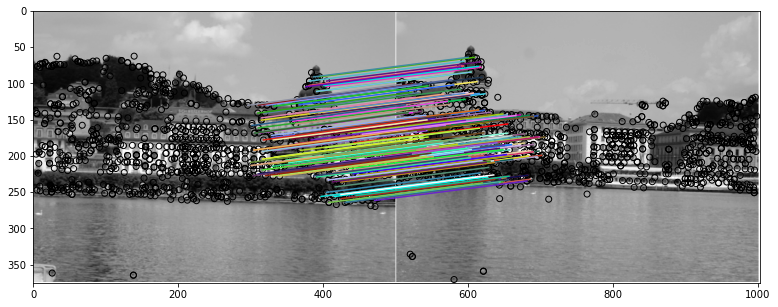

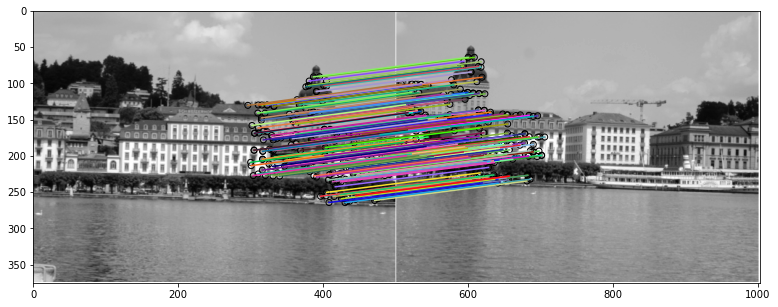

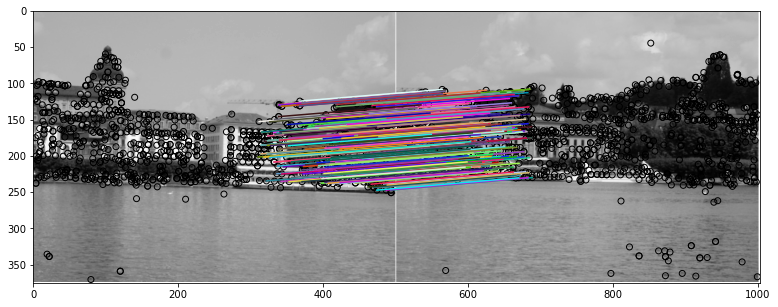

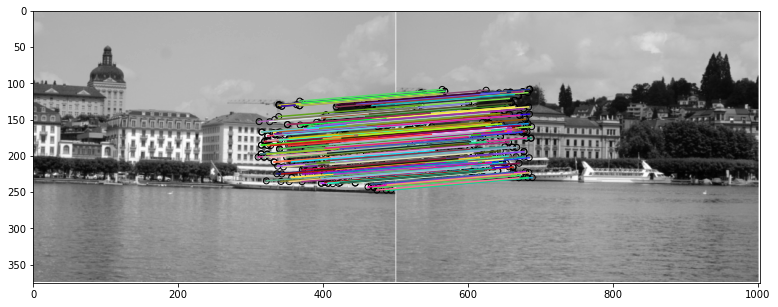

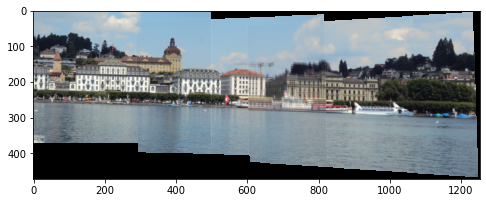

In [108]:
name = "pier"

images = [imread(f"{i+1}.jpg", as_gray=True, bonus=name) for i in range(3)]
matrix = register_images(
    images,
    method="consecutive",
    # SIFT feature extraction
    n_features=1000,
    n_octave_layers=3,
    contrast_threshold=0.04,
    edge_threshold=5,
    sigma=1.6,
    # putative matching
    extraction_ratio=1.5,
    # ransac
    residual_threshold=1,
    max_trials=10000,
    # debug
    show_features=False,
    show_putative_matches=False,
    show_ransac=True,
    show_homography_fitting=True,
)

# problem statement asks for colored panorama
images = [imread(f"{i+1}.jpg", as_gray=False, bonus=name) for i in range(3)]
images = np.array(images)
# we do each color separately
#   [i h w c] -> [c i h w]
#   [0 1 2 3] -> [3 0 1 2]
images = np.transpose(images, [3, 0, 1, 2])
images = list(images)

merged_split = []
for images_split in images:
    merged = stitch_images(images_split, matrix, method="consecutive")
    merged_split.append(merged)
merged_split = np.array(merged_split)
# convert back to comply with RGB
#   [c h w] -> [h w c]
#   [0 1 2] -> [1 2 0]
merged_split = np.transpose(merged_split, [1, 2, 0])

fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(merged_split)

imwrite("merged_average.png", merged_split, bonus=name)


## Blending by seam carving
The problem statement only states experiment with different image blending techniques. I choose to use seam carving to help image transition. Redo panorama mapping is too time consuming.

In [103]:
from skimage.filters import sobel

def find_cost_array(energy):
    ny, nx = energy.shape

    cost = np.zeros_like(energy)

    cost[ny-1,:] = energy[ny-1,:]
    for i in range(ny-2, -1, -1):
        for j in range(nx):
            c1, c2 = max(j-1, 0), min(nx, j+2)
            cost[i][j] = energy[i][j] + cost[i+1, c1:c2].min()
                
    return cost

def find_seam(cost):
    r, c = cost.shape
    
    path = []
    j = cost[0].argmin()
    path.append(j)
    
    for i in range(r-1):
        c1,c2 = max(j-1,0),min(c,j+2)
        j = max(j-1,0)+cost[i+1,c1:c2].argmin()
        path.append(j)

    return path

def find_seam2(cost0, cost1):
    ny, nx = cost0.shape

    path = []

    # start here
    x = cost0[0].argmin()
    print(f'find_seam2, start_x={x}')
    path.append(x)
    
    for y in range(ny-1):
        x1, x2 = max(x-1, 0), min(nx, x+1)
        # path follows the similar cost between cost0 and cost1
        delta_cost = np.abs(cost1[y+1, x1:x2+1] - cost0[y+1, x1:x2+1])
        x = max(x-1, 0) + delta_cost.argmin()
        path.append(x)

    return path

def mark_seam(im, path):
    im = im.copy()
    for y, p in enumerate(path):
        im[y, p:] = 0
    return im

def stitch_by_seam(im0, im1, path, invert):
    im = im0.copy()
    for y, p in enumerate(path):
        if not invert:
            im[y, p:] = im1[y, p:]
        else:
            im[y, :p] = im1[y, :p]
    return im
    
def stitch_images_seam(images, matrix, method="first", seams=None, show_unmerged=False):
    # build transformations
    _matrix = []
    m_ref = matrix[0]
    for m in matrix[1:]:
        _matrix.append(m_ref + m)
        if method == "consecutive":
            m_ref = m
    matrix = [matrix[0]] + _matrix

    # determine final output size
    corners_ref = shape_to_corners(images[0].shape)
    corners_ref_h = np.hstack([corners_ref, np.ones((4, 1))])

    extents = []
    for m in matrix:
        corners_dst = corners_ref_h @ m.params.T
        corners_dst = corners_dst[:, :-1] / corners_dst[:, -1][:, np.newaxis]
        extents.append(corners_dst)
    extents = np.vstack(extents)
    extent_max, extent_min = np.max(extents, axis=0), np.min(extents, axis=0)

    # convert as shape
    shape = np.ceil(extent_max - extent_min).astype(int)
    # reference image need to sheift `extent_min`
    offset = EuclideanTransform(translation=-extent_min)
    print(f"[final] (nx, ny)={tuple(shape)}, offset={tuple(-extent_min)}")
    # we work with (ny, nx) form
    shape = shape[::-1]

    # apply translation to every transformation
    matrix = [m + offset for m in matrix]

    # start warping everyone
    images_warp = []
    for im, m in zip(images, matrix):
        im_warp = warp(im, m.inverse, output_shape=shape)
        images_warp.append(im_warp)

    if show_unmerged:
        n = len(images_warp)
        fig, ax = plt.subplots(1, n, figsize=(15, 5 * n))
        for i, image in enumerate(images_warp):
            ax[i].imshow(image, cmap="gray")

    # calculate sobel as energy weights
    image0 = images_warp[0]
    if seams is None:
        seams = []
        for image1 in images_warp[1:]:
            # calculate overlaps
            mask_x_0 = np.sum(image0 > 0, axis=0) > 0
            mask_x_1 = np.sum(image1 > 0, axis=0) > 0
            # determine if we have inversion (image0 on right instead of left)
            c_x_0 = np.argwhere(mask_x_0).sum() / mask_x_0.sum()
            c_x_1 = np.argwhere(mask_x_1).sum() / mask_x_1.sum()
            invert = c_x_0 > c_x_1
            print(f'invert={invert}')

            fig, ax = plt.subplots(2, 1, figsize=(15, 10))
            ax[0].imshow(image0, cmap='gray')
            ax[1].imshow(image1, cmap='gray')

            # calculate sobel as energy weights
            energy0 = sobel(image0)
            energy1 = sobel(image1)    

            print('calculating cost')
            cost0 = find_cost_array(energy0)
            cost1 = find_cost_array(energy1)
            cost0 /= np.max(cost0)
            cost1 /= np.max(cost1)
            
            # use mask as boundary
            mask_x = np.nonzero(mask_x_0 & mask_x_1)[0]
            x_start, x_end = mask_x[0], mask_x[-1]
            x_start += 2
            x_end -=2
            print(f'overlapped x=[{x_start}, {x_end}]')
            
            # maximize cost around overlap boundary
            cost0[:, :x_start] = 1
            cost0[:, x_end+1:] = 1
            cost1[:, :x_start] = 0
            cost1[:, x_end+1:] = 0

            fig, ax = plt.subplots(2, 1, figsize=(15, 10))
            ax[0].imshow(cost0, cmap='gray')
            ax[1].imshow(cost1, cmap='gray')
            
            print('finding seam')
            path = find_seam2(cost0, cost1)
            seams.append(path)

            image0 = stitch_by_seam(image0, image1, path, invert)
            fig, ax = plt.subplots(figsize=(15, 5))
            ax.imshow(image0, cmap='gray')
    else:
        # use the provided seam
        for image1, path in zip(images_warp[1:], seams):
            # calculate overlaps
            mask_x_0 = np.sum(image0 > 0, axis=0) > 0
            mask_x_1 = np.sum(image1 > 0, axis=0) > 0
            # determine if we have inversion (image0 on right instead of left)
            c_x_0 = np.argwhere(mask_x_0).sum() / mask_x_0.sum()
            c_x_1 = np.argwhere(mask_x_1).sum() / mask_x_1.sum()
            invert = c_x_0 > c_x_1

            image0 = stitch_by_seam(image0, image1, path, invert)
            fig, ax = plt.subplots(figsize=(15, 5))
            ax.imshow(image0, cmap='gray')

    return image0, seams

image 0, 1000 keypoints
image 1, 1001 keypoints
image 2, 1001 keypoints
0<>1, 252 matches
1<>2, 315 matches
.. best_residual_mean=0.260644
.. best_inliers_num=77
0<>1, [ransac] 77 inliers
.. best_residual_mean=0.360441
.. best_inliers_num=143
1<>2, [ransac] 143 inliers
[final] (nx, ny)=(1268, 482), offset=(-0.0, 3.4833519963737554)
invert=False
calculating cost
overlapped x=[291, 498]
finding seam
find_seam2, start_x=498
invert=False
calculating cost
overlapped x=[603, 833]
finding seam
find_seam2, start_x=821
[final] (nx, ny)=(1268, 482), offset=(-0.0, 3.4833519963737554)
[final] (nx, ny)=(1268, 482), offset=(-0.0, 3.4833519963737554)


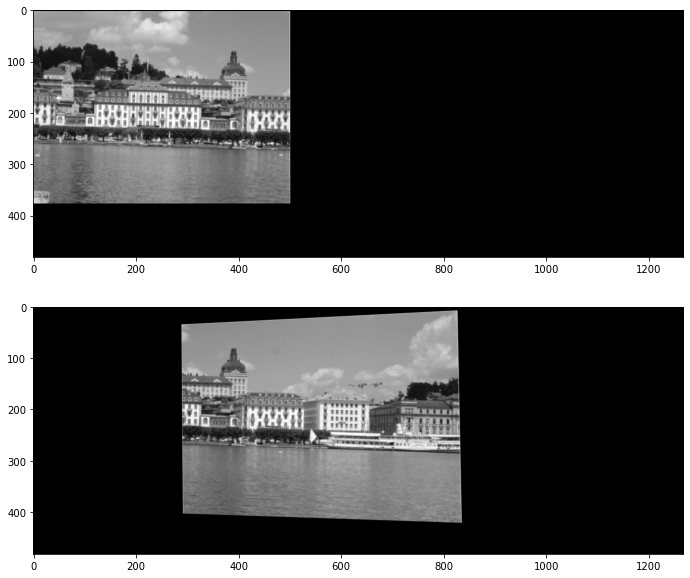

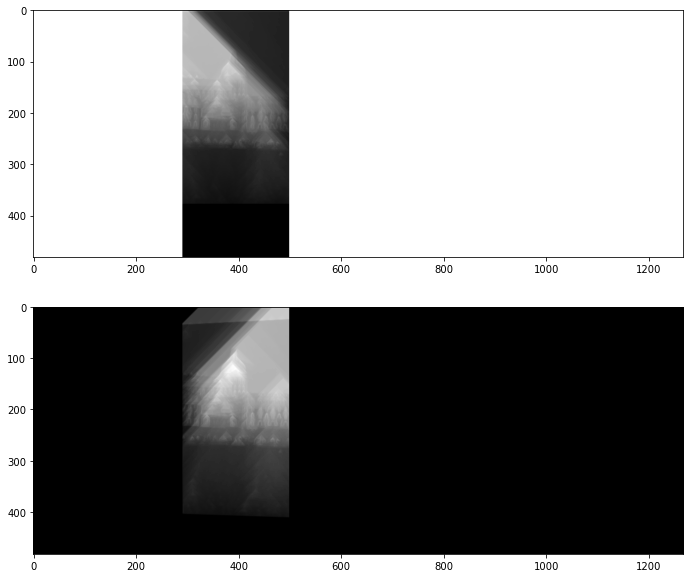

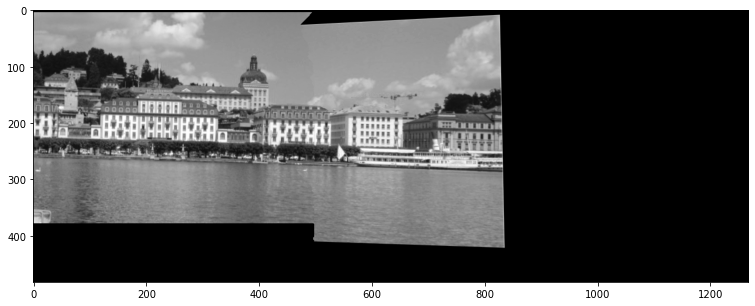

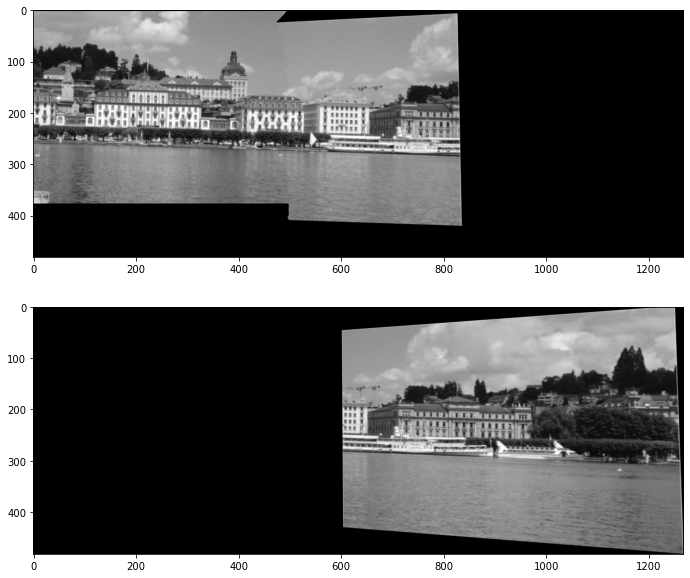

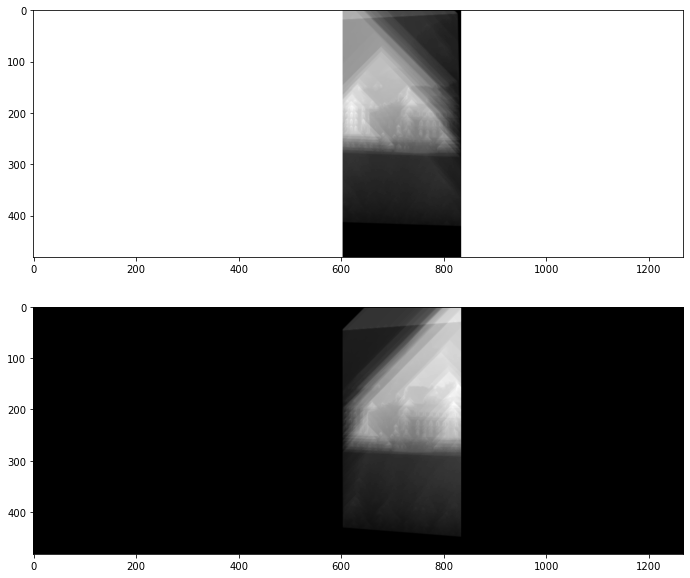

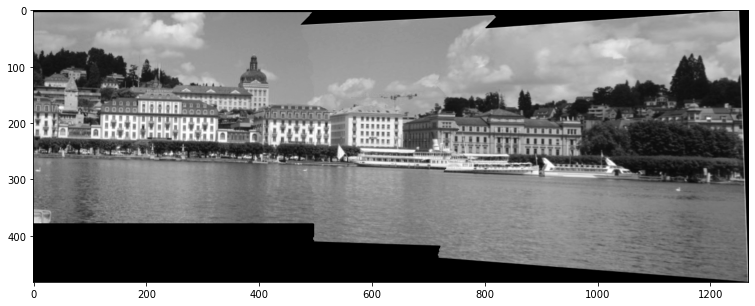

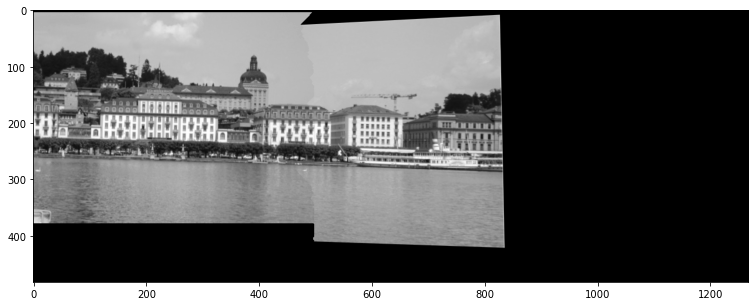

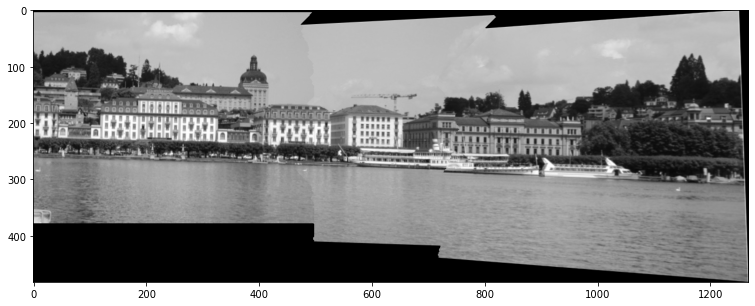

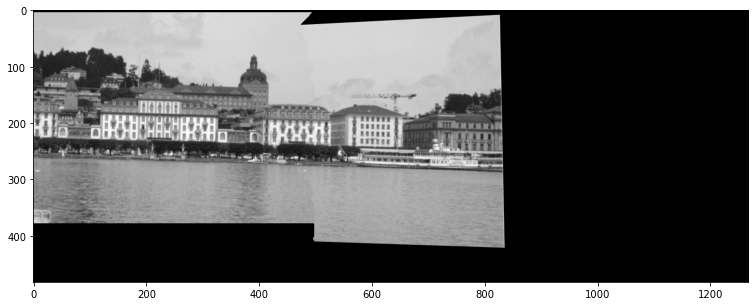

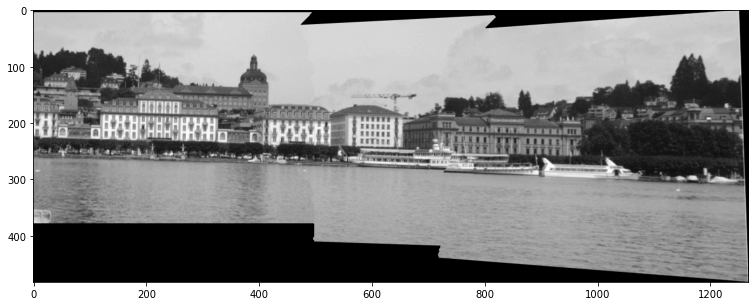

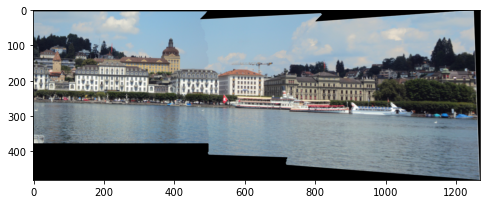

In [106]:
name = "pier"

images = [imread(f"{i+1}.jpg", as_gray=True, bonus=name) for i in range(3)]
matrix = register_images(
    images,
    method="consecutive",
    # SIFT feature extraction
    n_features=1000,
    n_octave_layers=3,
    contrast_threshold=0.04,
    edge_threshold=5,
    sigma=1.6,
    # putative matching
    extraction_ratio=1.5,
    # ransac
    residual_threshold=1,
    max_trials=10000,
    # debug
    show_features=False,
    show_putative_matches=False,
    show_ransac=False,
    show_homography_fitting=False,
)

# problem statement asks for colored panorama
images = [imread(f"{i+1}.jpg", as_gray=False, bonus=name) for i in range(3)]
images = np.array(images)
# we do each color separately
#   [i h w c] -> [c i h w]
#   [0 1 2 3] -> [3 0 1 2]
images = np.transpose(images, [3, 0, 1, 2])
images = list(images)

merged_split = []
seams = None
for images_split in images:
    merged, seams = stitch_images_seam(
        images_split, matrix, seams=seams, method="consecutive"
    )
    merged_split.append(merged)
merged_split = np.array(merged_split)
# convert back to comply with RGB
#   [c h w] -> [h w c]
#   [0 1 2] -> [1 2 0]
merged_split = np.transpose(merged_split, [1, 2, 0])

fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(merged_split)

imwrite("merged_seam.png", merged_split, bonus=name)
